16
4
Discrete(16)
Discrete(4)


Text(0.5, 1.0, '4x4 grid \n monte carlo control \n policy testing 1000 trials histogram')

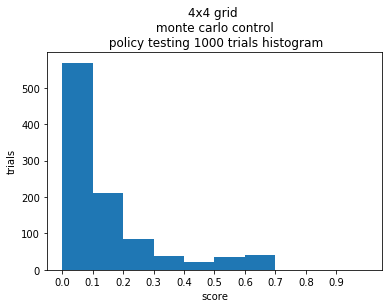

In [65]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt


# define a function to create epsilon-soft policy
def createRandomPolicyDict(env):
    policy={}
    for state in range(0,env.observation_space.n):
        p={}
        for action in range(0,env.action_space.n):
            p[action]=0.8/env.action_space.n
        policy[state]=p
    return policy

# define a function to create action values dictionary
def createActionValuesDict(env):
    Q={}
    for state in range(0,env.observation_space.n):
        v={}
        for action in range(0,env.action_space.n):
            v[action]=0.0
        Q[state]=v
    return Q

# define a function to run an episode
def runEpisode(env,policy):
    # reset state to starting state 0 whenever runEpisode is called
    env.reset()
    # tuple containing states for holes
    holes=(5,7,11,12)
    # tuple for goal state
    goal=(15,)
    # initialize an empty list to store sequence of (state,action,reward) in an episode
    episode=[]
    # flag to indicate whether episode is done i.e. a terminal state is reached
    done=False
    # if done flag is False, repeat
    while not done:
        # get current state
        state=env.env.s
        # simulate action selection based on policy
        cummulative_sum=0
        # sample a probability from uniform distribution
        prob=random.uniform(0,sum(policy[state].values()))
        # action a_i is chosen with i is the least i satisfying prob<sum_{i=0}^{i}p_i
        for p in policy[state].items():
            cummulative_sum=cummulative_sum+p[1]
            if cummulative_sum>prob:
                action=p[0]
                break
        # take action in the environment
        newstate,reward,done,info=env.step(action)
        # rewards obtained from traversing the environment
        if newstate in goal:
            reward=1.0
#             print('frisbee!')
        elif newstate in holes:
            reward=-1.0
        else:
            reward=0.0
        # append the triplet (state,action,reward) to the list, episode 
        episode=episode+[(state,action,reward)]
    return episode

# define function to test policy
def test_policy (env,policy):
    wins=0
    r=1000
    for i in range(r):
        #Calculate reward for each episode
        w= runEpisode(env,policy)[-1][-1]
        #If reward is 1, goal reached and it is a win!
        if w==1.0:
            wins+=1
    return wins/r

# define a function to implement first-visit Monte Carlo control without exploring starts
def monteCarloControl(env,n_episodes=1000,policy=None,epsilon=0.01):
    if not policy:
        # initialize random policy
        policy=createRandomPolicyDict(env)
    # initialize dictionary to store action values
    Q=createActionValuesDict(env)
    # initialize dictionary to store returns(s,a)
    returns={}
    # run episodes n_episodes times
    for _ in range(n_episodes):
        # run an episode
        episode=runEpisode(env,policy)
        # initialize cumulative discounted rewards variable, G
        G=0
        # print(episode)
        # initialize discount factor gamma
        gamma=0.8
        # starting from t=T-1 to t=0, perform backward computation for G
        for i in reversed(range(0,len(episode))):
            # obtain the state, action, and reward the corresponding time t
            s,a,r=episode[i]
            # initialize state-action tuple
            state_action=(s,a)
            # compute G using dynamic programming and Horner's rule
            G=G+gamma*r
            # for first visit monte carlo, G is included to the computation of returns(s,a) if only the tuple (s,a) was visited first in an episode
            if not state_action in [(x[0],x[1]) for x in episode[:i]]:
                # if the pair has been visited in previous episodes append G to returns(s,a)
                if returns.get(state_action):
                    # append G_t if the key, state_action pair has value/s in the returns(s,a)
                    returns[state_action].append(G)
                else:
                    # otherwise if state_action pair is visited the very first time and had not been visited in previous episodes,
                    returns[state_action]=[G]
                # store the average of the empirical returns in the action values dictionary
                Q[s][a]=sum(returns[state_action])/len(returns[state_action])
                # for the corresponding state, s, create a list of action values
                Q_list=[x[1] for x in Q[s].items()]
                # extract the maximum action value for that particular state
                Q_max=max(Q_list)
                # create a list of action(s) that gives the maximum action value
                actions=[]
                for x in Q[s].items():
                    if x[1]==Q_max:
                        actions.append(x[0])
                # pick a random action from the list of optimal action(s)
                A_star=random.choice(actions)
                # print(A_star)
                # update policy
                for a in policy[s].keys():
                    # epsilon greedy policy
                    if a==A_star:
                        # assign greedy policy for optimal action A_star
                        policy[s][a]=1-epsilon+epsilon/len(policy[s].keys())
                    else:
                        # assign epsilon-soft policy for other non optimal actions
                        policy[s][a]=epsilon/len(policy[s].keys())
    return policy

def showGridWorldAction(policy,env_size_tuple,holes,goal):
    n_row,n_col=env_size_tuple
    max_action_list=[]
    for x in policy.items():
        max_action_list.append(np.argmax(list(x[1].values())))
    row=''
    for i in range(0,len(max_action_list)):
        if i in holes:
            row=row+' H '
        elif i in goal:
            row=row+' G '
        else:
            if max_action_list[i]==0:
                row=row+' < '
            elif max_action_list[i]==1:
                row=row+' v '
            elif max_action_list[i]==2:
                row=row+' > '
            elif max_action_list[i]==3:
                row=row+' ^ '

        if (i+1)%n_col==0:
            print(row,'\n')
            row=''



# initialize FrozenLake environment from openai gym
env=gym.make('FrozenLake-v1')
# tuple containing states for holes
holes=(5,7,11,12)
# tuple for goal state
goal=(15,)
# number of default discrete states and actions in FrozenLake env
print(env.observation_space.n)
print(env.action_space.n)
print(env.observation_space)
print(env.action_space)
scores=[]
for i in range(0,1000):
    policy=monteCarloControl(env,n_episodes=1000)
#   print('policy=',policy)
#   showGridWorldAction(policy,(4,4),holes,goal)
    score=test_policy(env,policy)
    print(score)
    scores.append(score)
bins=np.linspace(0,1,11)
plt.hist(x=scores,bins=bins)
plt.ylabel('trials')
plt.xlabel('score')
plt.xticks(np.arange(0,1,0.1))
plt.title('4x4 grid \n monte carlo control \n policy testing 1000 trials histogram')



sarsa.py
score over time: -0.968
Q= [[-0.60660263 -0.64983949 -0.63611818 -0.61185153]
 [-0.98454118 -0.9868172  -0.92453272 -0.80935922]
 [-0.86286751 -0.45120274 -0.81517788 -0.68203275]
 [-0.89350006 -0.97497136 -0.92321736 -0.55608843]
 [-0.60042596 -0.99893898 -0.63309814 -0.42262266]
 [ 0.          0.          0.          0.        ]
 [-0.61456463 -0.93512237 -0.68651024 -0.53928078]
 [ 0.          0.          0.          0.        ]
 [-0.65453053 -0.94666838 -0.90995757 -0.81766822]
 [-0.8014708  -0.23507327 -0.98030233  0.21530336]
 [ 0.65655147 -0.92657257 -0.62233213 -0.8745107 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.52165506 -0.88606175 -0.8749492  -0.82055271]
 [-0.46666027 -0.46230406  0.5532331  -0.07088636]
 [ 0.          0.          0.          0.        ]] 

policy testing score: 0.0
0.083
0.053
0.044
0.002
0.19
0.261
0.397
0.152
0.234
0.145
0.0
0.004
0.043
0.182
0.001
0.033
0.185
0.032
0.116
0.131
0.

Text(0.5, 1.0, '4x4 grid \n SARSA \n policy testing 1000 trials histogram')

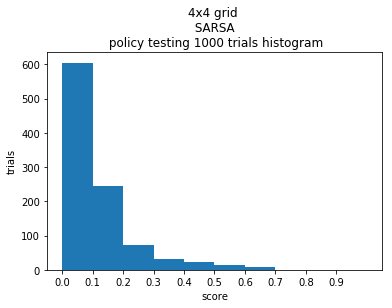

In [63]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt



# define a function to visualize actions taken by the agent in the FrozenLake gridworld
def showGridWorldAction(Q,env_size_tuple,holes,goal):
    # retrieve size of gridworld from env_size_tuple
    n_row,n_col=env_size_tuple
    # initialize a list to store optimal actions for each state
    max_action_list=[]
    # append optimal actions extracted from Q table
    for x in Q:
        max_action_list.append(np.argmax(x))
    # print actions taken in the gridworld env
    # initialize a string of actions taken in the gridworld row
    row=''
    # loop for index i, as the state s in the env
    for i in range(0,len(max_action_list)):
        # if the state is a hole, add H to the row string
        if i in holes:
            row=row+' H '
        # if the state is a goal, add G to the row string
        elif i in goal:
            row=row+' G '
        # otherwise, add the action left or down or right or up to the row string
        else:
            if max_action_list[i]==0:
                row=row+' < '
            elif max_action_list[i]==1:
                row=row+' v '
            elif max_action_list[i]==2:
                row=row+' > '
            elif max_action_list[i]==3:
                row=row+' ^ '
        # if the state is at the right edge of the gridworld env, continue to a new row below
        if (i+1)%n_col==0:
            # print row and a newline
            print(row,'\n')
            # reinitialize row to an empty string
            row=''

# define a function to implement sarsa for estimating q_star
def sarsa(env,n_episodes=1000,max_steps=100):
    # tuple containing states for holes
    holes=(5,7,11,12)
    # tuple for goal state
    goal=(15,)
    # initialize an np array to contain state-action values
    Q=np.random.uniform(low=0.0,high=1e-3,size=(env.observation_space.n,env.action_space.n))
    # tuple of terminal states
    terminal_states=holes+goal
    # assign 0 action values to terminal states
    for state in terminal_states:
        Q[state,:]=0.0
    # upper bound for epsilon
    max_epsilon=1.0
    # lower bound for epsilon
    min_epsilon=0.01
    # decay rate constant
    decay_constant=0.001
    # initialize epsilon to initial value of 1.0
    epsilon=1.0
    # learning rate alpha
    alpha=0.8
    # discount factor
    gamma=0.9
    # initialize an empty list to store rewards obtained over the n_episodes
    rewards=[]
    # execute n_episodes
    for episode in range(0,n_episodes):
        # reset state to 0 before performing any new episode
        env.reset()
        # initialize S
        state=env.env.s
        # choose A from S using epsilon-greedy policy
        # sample a probability from uniform distribution
        prob=random.uniform(0,1)
        # exploit if the sampled probability is greater than epsilon otherwise explore
        if prob>epsilon:
            # get greedy action
            action=np.argmax(Q[state,:])
        else:
            # pick a random action
            action=env.action_space.sample()
        # initialize total rewards collected from an episode
        total_rewards=0
        # flag to indicate whether episode is done i.e. a terminal state is reached
        done=False
        # take steps in the environment, terminate if steps taken has reached max_steps i.e. step=0-99
        for step in range(0,max_steps):
            # take action A in the environment
            next_state,reward,done,info=env.step(action)
            # reward obtained after visiting new state
            if next_state in goal:
                reward=1.0
#                 print('frisbee!')
            elif next_state in holes:
                reward=-1.0
            else:
                reward=0.0
            # choose A' from S' using epsilon-greedy policy
            prob=random.uniform(0,1)
            if prob>epsilon:
                next_action=np.argmax(Q[next_state,:])
            else:
                next_action=env.action_space.sample()
            # update estimated action value Q[S,A]
            delta_Q=alpha*(reward+gamma*Q[next_state,next_action]-Q[state,action])
            Q[state,action]=Q[state,action]+delta_Q
            # update total reward during the course
            total_rewards+=reward
            # redefine state S to be next state S'
            state=next_state
            # redefine action A to be next action A'
            action=next_action
            # if terminal state is reached, terminate episode
            if done:
                break
        # update epsilon for next episode, reduce its value to encourage exploitation in later episodes
        epsilon=min_epsilon+(max_epsilon-min_epsilon)*np.exp(-decay_constant*episode)
        # append total rewards obtained to rewards
        rewards.append(total_rewards)
#     print('gamma: {}'.format(gamma))
#     print('epsilon: {}-{}'.format(max_epsilon,min_epsilon))
#     print('alpha: {}'.format(alpha))
    # show optimal actions taken in the FrozenLake gridworld
#     showGridWorldAction(Q,(4,4),holes,goal)
    return Q,rewards

def extract_policy(Q,epsilon):
    n_row,n_col=Q.shape
    max_action_list=[]
    for x in Q:
        max_action_list.append(np.argmax(x))
    policy=np.zeros([n_row,n_col])
    for i in range(0,policy.shape[0]):
        policy[i]=[epsilon/n_col for j in range(0,n_col)]
    for i,j in zip(range(0,policy.shape[0]),max_action_list):
        policy[i][j]=1-epsilon+epsilon/n_col
    return policy

# define function to test policy
def test_policy (env,policy):
    wins=0
    r=1000
    for i in range(r):
        #Calculate reward for each episode
        w= runEpisode(env,policy)[-1][-1]
        #If reward is 1, goal reached and it is a win!
        if w==1.0:
            wins+=1
    return wins/r

# define a function to run an episode
def runEpisode(env,policy):
    # reset state to starting state 0 whenever runEpisode is called
    env.reset()
    # tuple containing states for holes
    holes=(5,7,11,12)
    # tuple for goal state
    goal=(15,)
    # initialize an empty list to store sequence of (state,action,reward) in an episode
    episode=[]
    # flag to indicate whether episode is done i.e. a terminal state is reached
    done=False
    # if done flag is False, repeat
    n_actions=policy.shape[1]
    while not done:
        # get current state
        state=env.env.s
        # simulate action selection based on policy
        cummulative_sum=0
        # sample a probability from uniform distribution
        prob=random.uniform(0,sum(policy[state]))
        # action a_i is chosen with i is the least i satisfying prob<sum_{i=0}^{i}p_i
        for i in range(0,n_actions):
            cummulative_sum=cummulative_sum+policy[state][i]
            if cummulative_sum>prob:
                action=i
                break
        # take action in the environment
        newstate,reward,done,info=env.step(action)
        # rewards obtained from traversing the environment
        if newstate in goal:
            reward=1.0
#             print('frisbee!')
        elif newstate in holes:
            reward=-1.0
        else:
            reward=0.0
        # append the triplet (state,action,reward) to the list, episode 
        episode=episode+[(state,action,reward)]
    return episode


# initialize FrozenLake environment from openai gym
env=gym.make('FrozenLake-v1')
total_episodes=1000
Q,rewards=sarsa(env,total_episodes)
print('score over time: '+str(sum(rewards)/total_episodes))
print('Q=',Q,'\n')
epsilon=0.01
policy=extract_policy(Q,epsilon)
score=test_policy(env,policy)
print('policy testing score:',score)
scores=[]
for i in range(0,1000):
    Q,rewards=sarsa(env,total_episodes)
    policy=extract_policy(Q,epsilon)
#         print('policy=',policy)
#         showGridWorldAction(policy,(4,4),holes,goal)
    score=test_policy(env,policy)
    print(score)
#         print(score)
    scores.append(score)
bins=np.linspace(0,1,11)
plt.hist(x=scores,bins=bins)
plt.ylabel('trials')
plt.xlabel('score')
plt.xticks(np.arange(0,1,0.1))
plt.title('4x4 grid \n SARSA \n policy testing 1000 trials histogram')


score over time: -0.962
Q= [[ 0.25418658  0.20589113  0.22876792  0.22876792]
 [-1.         -1.          0.09847709  0.22876792]
 [ 0.09847709  0.0717898   0.09847709  0.3138106 ]
 [-1.         -1.         -1.          0.09847709]
 [ 0.25418658  0.25418658  0.22876792 -1.        ]
 [ 0.          0.          0.          0.        ]
 [-1.         -1.         -1.         -1.        ]
 [ 0.          0.          0.          0.        ]
 [-1.         -1.         -1.          0.38742049]
 [ 0.531441    0.43046721 -1.          0.34867844]
 [ 0.59049    -1.         -1.         -0.9       ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.59049    -1.          0.59049     0.28242954]
 [ 0.43046721  0.59049     0.9         1.        ]
 [ 0.          0.          0.          0.        ]] 

policy testing score: 0.0
0.04
0.04
0.13
0.13
0.154
0.154
0.199
0.199
0.132
0.132
0.015
0.015
0.001
0.001
0.038
0.038
0.111
0.111
0.004
0.004
0.163
0.163


0.001
0.001
0.063
0.063
0.108
0.108
0.001
0.001
0.15
0.15
0.145
0.145
0.214
0.214
0.214
0.214
0.192
0.192
0.188
0.188
0.125
0.125
0.015
0.015
0.001
0.001
0.5
0.5
0.077
0.077
0.026
0.026
0.115
0.115
0.012
0.012
0.074
0.074
0.311
0.311
0.011
0.011
0.003
0.003
0.139
0.139
0.039
0.039
0.056
0.056
0.069
0.069
0.036
0.036
0.088
0.088
0.078
0.078
0.062
0.062
0.171
0.171
0.072
0.072
0.496
0.496
0.233
0.233
0.177
0.177
0.071
0.071
0.0
0.0
0.026
0.026
0.002
0.002
0.037
0.037
0.001
0.001
0.063
0.063
0.185
0.185
0.066
0.066
0.146
0.146
0.006
0.006
0.0
0.0
0.132
0.132
0.552
0.552
0.081
0.081
0.048
0.048
0.196
0.196
0.0
0.0
0.005
0.005
0.0
0.0
0.015
0.015
0.148
0.148
0.065
0.065
0.105
0.105
0.254
0.254
0.002
0.002
0.692
0.692
0.273
0.273
0.467
0.467
0.0
0.0
0.127
0.127
0.172
0.172
0.094
0.094
0.001
0.001
0.001
0.001
0.003
0.003
0.24
0.24
0.0
0.0
0.063
0.063
0.096
0.096
0.076
0.076
0.108
0.108
0.055
0.055
0.0
0.0
0.078
0.078
0.114
0.114
0.099
0.099
0.003
0.003
0.238
0.238
0.0
0.0
0.057
0.057
0.083
0.

Text(0.5, 1.0, '4x4 grid \n Q Learning \n policy testing 1000 trials histogram')

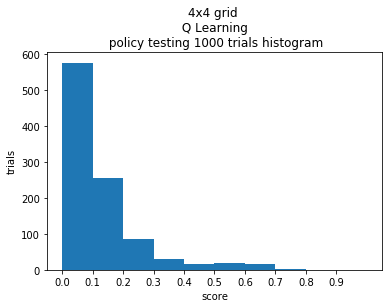

In [68]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt


# define a function to visualize actions taken by the agent in the FrozenLake gridworld
def showGridWorldAction(Q,env_size_tuple,holes,goal):
    # retrieve size of gridworld from env_size_tuple
    n_row,n_col=env_size_tuple
    # initialize a list to store optimal actions for each state
    max_action_list=[]
    # append optimal actions extracted from Q table
    for x in Q:
        max_action_list.append(np.argmax(x))
    # print actions taken in the gridworld env
    # initialize a string of actions taken in the gridworld row
    row=''
    # loop for index i, as the state s in the env
    for i in range(0,len(max_action_list)):
        # if the state is a hole, add H to the row string
        if i in holes:
            row=row+' H '
        # if the state is a goal, add G to the row string
        elif i in goal:
            row=row+' G '
        # otherwise, add action left or down or right or up to the row string
        else:
            if max_action_list[i]==0:
                row=row+' < '
            elif max_action_list[i]==1:
                row=row+' v '
            elif max_action_list[i]==2:
                row=row+' > '
            elif max_action_list[i]==3:
                row=row+' ^ '
        # if the state is at the right edge of the gridworld env, continue to a new row below
        if (i+1)%n_col==0:
            # print row and a newline
            print(row,'\n')
            # reinitialize row to an empty string
            row=''

# define a function to implement Q-learning to obtain optimal action values q_star
def Q_learning(env,n_episodes=1000,max_steps=100):
    # tuple containing states for holes
    holes=(5,7,11,12)
    # tuple for goal state
    goal=(15,)
    # initialize an np array to contain state-action values
    Q=np.random.uniform(low=0.0,high=1e-3,size=(env.observation_space.n,env.action_space.n))
    # tuple of terminal states
    terminal_states=holes+goal
    # assign 0 action values to terminal states
    for state in terminal_states:
        Q[state,:]=0.0
    # upper bound for epsilon
    max_epsilon=1.0
    # lower bound for epsilon
    min_epsilon=0.01
    # decay rate constant
    decay_constant=0.001
    # initialize epsilon to initial value of 1.0
    epsilon=1.0
    # learning rate alpha
    alpha=0.8
    # discount factor
    gamma=0.9
    # initialize an empty list to store rewards obtained over the n_episodes
    rewards=[]
    # execute n_episodes
    for episode in range(0,n_episodes):
        # reset state to 0 before performing any new episode
        env.reset()
        # initialize s
        state=env.env.s
        # initialize total rewards collected from an episode
        total_rewards=0
        # flag to indicate whether episode is done i.e. a terminal state is reached
        done=False
        # take steps in the environment, terminate if steps taken has reached max_steps i.e. step=0-99
        for step in range(0,max_steps):
            # choose A from S using epsilon-greedy policy
            # sample a probability from uniform distribution
            prob=random.uniform(0,1)
            # exploit if the sampled probability is greater than epsilon otherwise explore
            if prob>epsilon:
                # get greedy action
                action=np.argmax(Q[state,:])
            else:
                # pick a random action
                action=env.action_space.sample()
            # take action in the environment
            new_state,reward,done,info=env.step(action)
            # reward obtained after visiting new state
            if new_state in goal:
                reward=1.0
#                 print('frisbee!')
            elif new_state in holes:
                reward=-1.0
            else:
                reward=0.0
            # update estimated action value Q[S,A]
            delta_Q=reward+gamma*np.max(Q[new_state,:])-Q[state,action]
            Q[state,action]=Q[state,action]+delta_Q
            # update total reward during the course
            total_rewards+=reward
            # redefine state S to be new state S'
            state=new_state
            # if terminal state is reached, terminate episode
            if done:
                break
        # update epsilon for next episode, reduce its value to encourage exploitation in later episodes
        epsilon=min_epsilon+(max_epsilon-min_epsilon)*np.exp(-decay_constant*episode)
        # append total rewards obtained to rewards
        rewards.append(total_rewards)
#     print('gamma: {}'.format(gamma))
#     print('epsilon: {}-{}'.format(max_epsilon,min_epsilon))
#     print('alpha: {}'.format(alpha))
    # show optimal actions taken in the FrozenLake gridworld
#     showGridWorldAction(Q,(4,4),holes,goal)
    return Q,rewards

def extract_policy(Q,epsilon):
    n_row,n_col=Q.shape
    max_action_list=[]
    for x in Q:
        max_action_list.append(np.argmax(x))
    policy=np.zeros([n_row,n_col])
    for i in range(0,policy.shape[0]):
        policy[i]=[epsilon/n_col for j in range(0,n_col)]
    for i,j in zip(range(0,policy.shape[0]),max_action_list):
        policy[i][j]=1-epsilon+epsilon/n_col
    return policy

# define function to test policy
def test_policy (env,policy):
    wins=0
    r=1000
    for i in range(r):
        #Calculate reward for each episode
        w= runEpisode(env,policy)[-1][-1]
        #If reward is 1, goal reached and it is a win!
        if w==1.0:
            wins+=1
    return wins/r

# define a function to run an episode
def runEpisode(env,policy):
    # reset state to starting state 0 whenever runEpisode is called
    env.reset()
    # tuple containing states for holes
    holes=(5,7,11,12)
    # tuple for goal state
    goal=(15,)
    # initialize an empty list to store sequence of (state,action,reward) in an episode
    episode=[]
    # flag to indicate whether episode is done i.e. a terminal state is reached
    done=False
    # if done flag is False, repeat
    n_actions=policy.shape[1]
    while not done:
        # get current state
        state=env.env.s
        # simulate action selection based on policy
        cummulative_sum=0
        # sample a probability from uniform distribution
        prob=random.uniform(0,sum(policy[state]))
        # action a_i is chosen with i is the least i satisfying prob<sum_{i=0}^{i}p_i
        for i in range(0,n_actions):
            cummulative_sum=cummulative_sum+policy[state][i]
            if cummulative_sum>prob:
                action=i
                break
        # take action in the environment
        newstate,reward,done,info=env.step(action)
        # rewards obtained from traversing the environment
        if newstate in goal:
            reward=1.0
#             print('frisbee!')
        elif newstate in holes:
            reward=-1.0
        else:
            reward=0.0
        # append the triplet (state,action,reward) to the list, episode 
        episode=episode+[(state,action,reward)]
    return episode


# initialize FrozenLake environment from openai gym
env=gym.make('FrozenLake-v1')
total_episodes=1000
Q,rewards=Q_learning(env,total_episodes)
print('score over time: '+str(sum(rewards)/total_episodes))
print('Q=',Q,'\n')
epsilon=0.01
policy=extract_policy(Q,epsilon)
score=test_policy(env,policy)
print('policy testing score:',score)
scores=[]
for i in range(0,1000):
    Q,rewards=Q_learning(env,total_episodes)
    policy=extract_policy(Q,epsilon)
#   print('policy=',policy)
#   showGridWorldAction(policy,(4,4),holes,goal)
    score=test_policy(env,policy)
    print(score)
    print(score)
    scores.append(score)
bins=np.linspace(0,1,11)
plt.hist(x=scores,bins=bins)
plt.ylabel('trials')
plt.xlabel('score')
plt.xticks(np.arange(0,1,0.1))
plt.title('4x4 grid \n Q Learning \n policy testing 1000 trials histogram')


sarsa_extended
Q= [[-4.33756807e-01 -3.73809067e-01 -3.33132474e-01 -1.02858116e-02]
 [-6.62847146e-01 -6.42313883e-01 -6.51185157e-01 -1.52608305e-02]
 [-9.92839674e-01 -8.32612205e-01 -8.29887953e-01 -1.77472556e-02]
 [-4.38781013e-01 -6.24844307e-01 -4.44689574e-01 -3.86477327e-02]
 [-8.93166654e-02 -8.47112977e-01 -8.35644046e-01 -8.05343593e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.99915688e-01 -6.40698777e-03 -7.99952092e-01 -7.99986626e-01]
 [-2.04380369e-02 -1.02335846e-01 -9.18255605e-05 -5.11863231e-01]
 [-2.54721426e-03 -6.42837030e-05 -2.59052669e-03 -5.52435718e-03]
 [-3.92724560e-05 -2.14064478e-03 -1.16967583e-03 -1.89844674e-03]
 [-3.34051371e-03 -6.21860044e-01 -7.43921009e-01 -7.18195094e-01]
 [-9.99684996e-01 -9.98936064e-01 -9.99743299e-01 -9.98969120e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.52819304e-01 -8.55196407e-01 -2.57814960e-02 -9.71450034e-01]
 [-9.63103666e-01 -9.70378874e-01 -9.9651012

0.003
progress: 79
0.001
progress: 80
0.008
progress: 81
0.004
progress: 82
0.004
progress: 83
0.0
progress: 84
0.002
progress: 85
0.002
progress: 86
0.002
progress: 87
0.003
progress: 88
0.0
progress: 89
0.008
progress: 90
0.003
progress: 91
0.001
progress: 92
0.003
progress: 93
0.005
progress: 94
0.006
progress: 95
0.004
progress: 96
0.002
progress: 97
0.001
progress: 98
0.002
progress: 99
0.005
progress: 100
0.002
progress: 101
0.006
progress: 102
0.003
progress: 103
0.003
progress: 104
0.004
progress: 105
0.002
progress: 106
0.005
progress: 107
0.002
progress: 108
0.004
progress: 109
0.004
progress: 110
0.001
progress: 111
0.0
progress: 112
0.002
progress: 113
0.004
progress: 114
0.005
progress: 115
0.001
progress: 116
0.0
progress: 117
0.001
progress: 118
0.009
progress: 119
0.001
progress: 120
0.003
progress: 121
0.002
progress: 122
0.004
progress: 123
0.008
progress: 124
0.01
progress: 125
0.004
progress: 126
0.003
progress: 127
0.003
progress: 128
0.001
progress: 129
0.004
prog

0.006
progress: 495
0.0
progress: 496
0.005
progress: 497
0.003
progress: 498
0.003
progress: 499
0.0
progress: 500
0.005
progress: 501
0.0
progress: 502
0.002
progress: 503
0.007
progress: 504
0.005
progress: 505
0.001
progress: 506
0.003
progress: 507
0.001
progress: 508
0.003
progress: 509
0.004
progress: 510
0.004
progress: 511
0.009
progress: 512
0.003
progress: 513
0.001
progress: 514
0.002
progress: 515
0.003
progress: 516
0.0
progress: 517
0.003
progress: 518
0.002
progress: 519
0.0
progress: 520
0.002
progress: 521
0.002
progress: 522
0.004
progress: 523
0.004
progress: 524
0.006
progress: 525
0.002
progress: 526
0.002
progress: 527
0.001
progress: 528
0.003
progress: 529
0.007
progress: 530
0.001
progress: 531
0.0
progress: 532
0.002
progress: 533
0.004
progress: 534
0.003
progress: 535
0.004
progress: 536
0.003
progress: 537
0.003
progress: 538
0.003
progress: 539
0.006
progress: 540
0.003
progress: 541
0.006
progress: 542
0.004
progress: 543
0.003
progress: 544
0.003
progre

0.002
progress: 909
0.006
progress: 910
0.003
progress: 911
0.001
progress: 912
0.002
progress: 913
0.0
progress: 914
0.003
progress: 915
0.0
progress: 916
0.004
progress: 917
0.004
progress: 918
0.003
progress: 919
0.004
progress: 920
0.0
progress: 921
0.002
progress: 922
0.002
progress: 923
0.001
progress: 924
0.0
progress: 925
0.002
progress: 926
0.002
progress: 927
0.003
progress: 928
0.003
progress: 929
0.0
progress: 930
0.002
progress: 931
0.005
progress: 932
0.002
progress: 933
0.006
progress: 934
0.003
progress: 935
0.005
progress: 936
0.003
progress: 937
0.0
progress: 938
0.005
progress: 939
0.002
progress: 940
0.002
progress: 941
0.003
progress: 942
0.002
progress: 943
0.001
progress: 944
0.003
progress: 945
0.002
progress: 946
0.002
progress: 947
0.001
progress: 948
0.001
progress: 949
0.004
progress: 950
0.003
progress: 951
0.003
progress: 952
0.002
progress: 953
0.004
progress: 954
0.005
progress: 955
0.004
progress: 956
0.003
progress: 957
0.006
progress: 958
0.0
progress

Text(0.5, 1.0, '10x10 grid \n extended SARSA \n policy testing 1000 trials histogram')

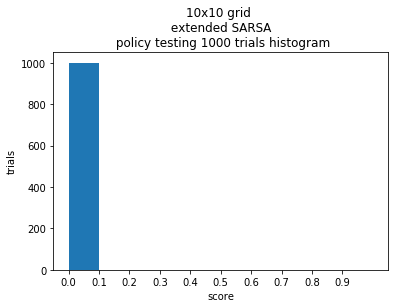

In [76]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt


# define a function to visualize actions taken by the agent in the FrozenLake gridworld
def showGridWorldAction(Q,env_size_tuple,holes,goal):
    # retrieve size of gridworld from env_size_tuple
    n_row,n_col=env_size_tuple
    # initialize a list to store optimal actions for each state
    max_action_list=[]
    # append optimal actions extracted from Q table
    for x in Q:
        max_action_list.append(np.argmax(x))
    # print actions taken in the gridworld env
    # initialize a string of actions taken in the gridworld row
    row=''
    # loop for index i, as the state s in the env
    for i in range(0,len(max_action_list)):
        # if the state is a hole, add H to the row string
        if i in holes:
            row=row+' H '
        # if the state is a goal, add G to the row string
        elif i in goal:
            row=row+' G '
        # otherwise, add the action left or down or right or up to the row string
        else:
            if max_action_list[i]==0:
                row=row+' < '
            elif max_action_list[i]==1:
                row=row+' v '
            elif max_action_list[i]==2:
                row=row+' > '
            elif max_action_list[i]==3:
                row=row+' ^ '
        # if the state is at the right edge of the gridworld env, continue to a new row below
        if (i+1)%n_col==0:
            # print row and a newline
            print(row,'\n')
            # reinitialize row to an empty string
            row=''

# define a function to implement sarsa for estimating q_star
def sarsa_extended(env,n_episodes=20000,max_steps=100):
    # tuple containing states for holes
    holes=(5,12,16,21,24,34,37,40,45,49,52,53,56,57,61,66,68,72,75,77,80,85,88,90,93)
    # tuple for goal state
    goal=(99,)
    # initialize an np array to contain state-action values
    Q=np.random.uniform(low=0.0,high=1e-3,size=(env.observation_space.n,env.action_space.n))
    # tuple of terminal states
    terminal_states=holes+goal
    # assign 0 action values to terminal states
    for state in terminal_states:
        Q[state,:]=0.0
    # upper bound for epsilon
    max_epsilon=1.0
    # lower bound for epsilon
    min_epsilon=0.001
    # initialize epsilon to initial value of 1.0
    epsilon=1.0
    # learning rate alpha
    alpha=1.0
    max_alpha=1.0
    min_alpha=0.8
    # discount factor
    gamma=0.8
    # initialize an empty list to store rewards obtained over the n_episodes
    rewards=[]
    # timesteps
#     timesteps=[]
    # decay rate constant
    decay_constant=0.1
    # number of frisbees obtained
#     n_frisbees=0
    # execute n_episodes
    for episode in range(0,n_episodes):

        # reset state to 0 before performing any new episode
        env.reset()
        # initialize S
        state=env.env.s
        # choose A from S using epsilon-greedy policy
        # sample a probability from uniform distribution
        prob=random.uniform(0,1)
        # exploit if the sampled probability is greater than epsilon otherwise explore
        if prob>epsilon:
            # get greedy action
            action=np.argmax(Q[state,:])
        else:
            # pick a random action
            action=env.action_space.sample()
        # initialize total rewards collected from an episode
        total_rewards=0
        # flag to indicate whether episode is done i.e. a terminal state is reached
        done=False
        # take steps in the environment, terminate if steps taken has reached max_steps i.e. step=0-99
        steps=0
        for step in range(0,max_steps):
            steps=steps+1
            # take action A in the environment
            next_state,reward,done,info=env.step(action)
            # reward obtained after visiting new state
            if next_state in goal:
                reward=1.0
#                 n_frisbees+=1
#                 print('frisbee!')
            elif next_state in holes:
                reward=-1.0
            else:
                reward=0.0
            # choose A' from S' using epsilon-greedy policy
            prob=random.uniform(0,1)
            if prob>epsilon:
                next_action=np.argmax(Q[next_state,:])
            else:
                next_action=env.action_space.sample()
            # update estimated action value Q[S,A]
            delta_Q=alpha*(reward+gamma*Q[next_state,next_action]-Q[state,action])
            Q[state,action]=Q[state,action]+delta_Q
            # update total reward during the course
            total_rewards+=reward
            # redefine state S to be next state S'
            state=next_state
            # redefine action A to be next action A'
            action=next_action
            # if terminal state is reached, terminate episode
            if done:
                break
            
        # update epsilon for next episode, reduce its value to encourage exploitation in later episodes
        epsilon=min_epsilon+(max_epsilon-min_epsilon)*np.exp(-decay_constant*episode)
        # decrease learning rate in later episodes
        alpha=min_alpha+(max_alpha-min_alpha)*np.exp(-decay_constant*episode)
        # append total rewards obtained to rewards
        rewards.append(total_rewards)
#         timesteps.append(steps)
#     print('gamma: {}'.format(gamma))
#     print('epsilon: {}-{}'.format(max_epsilon,min_epsilon))
#     print('alpha: {}-{}'.format(max_alpha,min_alpha))
#     print('{} frisbees obtained in {} episodes'.format(n_frisbees,n_episodes))
#     print('average timesteps taken: {}'.format(np.mean(timesteps)))
#     print('score over time: '+str(sum(rewards)/n_episodes))
    # show optimal actions taken in the FrozenLake gridworld
#     showGridWorldAction(Q,(10,10),holes,goal)
    return Q,rewards

def extract_policy(Q,epsilon):
    n_row,n_col=Q.shape
    max_action_list=[]
    for x in Q:
        max_action_list.append(np.argmax(x))
    policy=np.zeros([n_row,n_col])
    for i in range(0,policy.shape[0]):
        policy[i]=[epsilon/n_col for j in range(0,n_col)]
    for i,j in zip(range(0,policy.shape[0]),max_action_list):
        policy[i][j]=1-epsilon+epsilon/n_col
    return policy

# define function to test policy
def test_policy (env,policy):
    wins=0
    r=1000
    for i in range(r):
        #Calculate reward for each episode
        w= runEpisode(env,policy)[-1][-1]
        #If reward is 1, goal reached and it is a win!
        if w==1.0:
            wins+=1
    return wins/r

# define a function to run an episode
def runEpisode(env,policy):
    # reset state to starting state 0 whenever runEpisode is called
    env.reset()
    # tuple containing states for holes
    holes=(5,12,16,21,24,34,37,40,45,49,52,53,56,57,61,66,68,72,75,77,80,85,88,90,93)
    # tuple for goal state
    goal=(99,)
    # initialize an empty list to store sequence of (state,action,reward) in an episode
    episode=[]
    # flag to indicate whether episode is done i.e. a terminal state is reached
    done=False
    # if done flag is False, repeat
    n_actions=policy.shape[1]
    while not done:
        # get current state
        state=env.env.s
        # simulate action selection based on policy
        cummulative_sum=0
        # sample a probability from uniform distribution
        prob=random.uniform(0,sum(policy[state]))
        # action a_i is chosen with i is the least i satisfying prob<sum_{i=0}^{i}p_i
        for i in range(0,n_actions):
            cummulative_sum=cummulative_sum+policy[state][i]
            if cummulative_sum>prob:
                action=i
                break
        # take action in the environment
        newstate,reward,done,info=env.step(action)
        # rewards obtained from traversing the environment
        if newstate in goal:
            reward=1.0
#             print('frisbee!')
        elif newstate in holes:
            reward=-1.0
        else:
            reward=0.0
        # append the triplet (state,action,reward) to the list, episode 
        episode=episode+[(state,action,reward)]
    return episode


print('sarsa_extended')
# create custom map for extended grid of 10x10 (25 hole states, 1 goal state, 1 start state)
custom_map=['SFFFFHFFFF',
            'FFHFFFHFFF',
            'FHFFHFFFFF',
            'FFFFHFFHFF',
            'HFFFFHFFFH',
            'FFHHFFHHFF',
            'FHFFFFHFHF',
            'FFHFFHFHFF',
            'HFFFFHFFHF',
            'HFFHFFFFFG']

# initialize FrozenLake environment from openai gym
env=gym.make('FrozenLake-v1',desc=custom_map)
# tuple containing states for holes
holes=(5,12,16,21,24,34,37,40,45,49,52,53,56,57,61,66,68,72,75,77,80,85,88,90,93)
# tuple for goal state
goal=(99,)
total_episodes=20000
Q,rewards=sarsa_extended(env,total_episodes)
print('Q=',Q,'\n')
epsilon=0.01
policy=extract_policy(Q,epsilon)
score=test_policy(env,policy)
print('policy testing score:',score)
scores=[]
progress=0
for i in range(0,1000):
    Q,rewards=sarsa_extended(env,total_episodes)
    policy=extract_policy(Q,epsilon)
#         print('policy=',policy)
#         showGridWorldAction(policy,(10,10),holes,goal)
    score=test_policy(env,policy)
    print(score)
    progress+=1
    print('progress:',progress)
#         print(score)
    scores.append(score)
bins=np.linspace(0,1,11)
plt.hist(x=scores,bins=bins)
plt.ylabel('trials')
plt.xlabel('score')
plt.xticks(np.arange(0,1,0.1))
plt.title('10x10 grid \n extended SARSA \n policy testing 1000 trials histogram')



In [77]:
scores

[0.001,
 0.003,
 0.002,
 0.005,
 0.001,
 0.005,
 0.004,
 0.006,
 0.001,
 0.002,
 0.004,
 0.006,
 0.003,
 0.007,
 0.0,
 0.003,
 0.001,
 0.004,
 0.002,
 0.003,
 0.001,
 0.0,
 0.002,
 0.003,
 0.001,
 0.004,
 0.0,
 0.002,
 0.001,
 0.0,
 0.003,
 0.001,
 0.004,
 0.0,
 0.003,
 0.001,
 0.003,
 0.001,
 0.002,
 0.002,
 0.006,
 0.001,
 0.004,
 0.004,
 0.005,
 0.003,
 0.006,
 0.002,
 0.0,
 0.002,
 0.004,
 0.004,
 0.005,
 0.007,
 0.0,
 0.006,
 0.003,
 0.007,
 0.006,
 0.001,
 0.001,
 0.007,
 0.003,
 0.001,
 0.0,
 0.004,
 0.003,
 0.002,
 0.003,
 0.001,
 0.004,
 0.004,
 0.0,
 0.004,
 0.002,
 0.005,
 0.002,
 0.001,
 0.003,
 0.001,
 0.008,
 0.004,
 0.004,
 0.0,
 0.002,
 0.002,
 0.002,
 0.003,
 0.0,
 0.008,
 0.003,
 0.001,
 0.003,
 0.005,
 0.006,
 0.004,
 0.002,
 0.001,
 0.002,
 0.005,
 0.002,
 0.006,
 0.003,
 0.003,
 0.004,
 0.002,
 0.005,
 0.002,
 0.004,
 0.004,
 0.001,
 0.0,
 0.002,
 0.004,
 0.005,
 0.001,
 0.0,
 0.001,
 0.009,
 0.001,
 0.003,
 0.002,
 0.004,
 0.008,
 0.01,
 0.004,
 0.003,
 0.003,
 0.

Text(0.5, 1.0, '10x10 grid \n extended SARSA \n policy testing 1000 trials histogram')

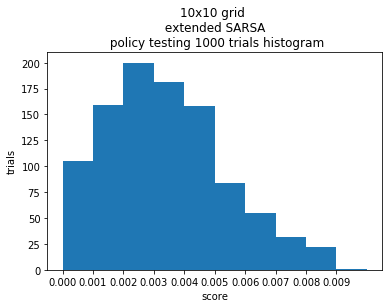

In [95]:
bins=np.linspace(0,0.01,11)
plt.hist(x=scores,bins=bins)
plt.ylabel('trials')
plt.xlabel('score')
plt.xticks(np.arange(0,0.01,0.001))
plt.title('10x10 grid \n extended SARSA \n policy testing 1000 trials histogram')

In [4]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt


# define a function to visualize actions taken by the agent in the FrozenLake gridworld
def showGridWorldAction(Q,env_size_tuple,holes,goal):
    # retrieve size of gridworld from env_size_tuple
    n_row,n_col=env_size_tuple
    # initialize a list to store optimal actions for each state
    max_action_list=[]
    # append optimal actions extracted from Q table
    for x in Q:
        max_action_list.append(np.argmax(x))
    # print actions taken in the gridworld env
    # initialize a string of actions taken in the gridworld row
    row=''
    # loop for index i, as the state s in the env
    for i in range(0,len(max_action_list)):
        # if the state is a hole, add H to the row string
        if i in holes:
            row=row+' H '
        # if the state is a goal, add G to the row string
        elif i in goal:
            row=row+' G '
        # otherwise, add action left or down or right or up to the row string
        else:
            if max_action_list[i]==0:
                row=row+' < '
            elif max_action_list[i]==1:
                row=row+' v '
            elif max_action_list[i]==2:
                row=row+' > '
            elif max_action_list[i]==3:
                row=row+' ^ '
        # if the state is at the right edge of the gridworld env, continue to a new row below
        if (i+1)%n_col==0:
            # print row and a newline
            print(row,'\n')
            # reinitialize row to an empty string
            row=''

# define a function to implement Q-learning to obtain optimal action values q_star
def Q_learning_extended(env,n_episodes=20000,max_steps=100):
    # tuple containing states for holes
    holes=(5,12,16,21,24,34,37,40,45,49,52,53,56,57,61,66,68,72,75,77,80,85,88,90,93)
    # tuple for goal state
    goal=(99,)
    # initialize an np array to contain state-action values
    Q=np.random.uniform(low=0.0,high=1e-3,size=(env.observation_space.n,env.action_space.n))
    # tuple of terminal states
    terminal_states=holes+goal
    # assign 0 action values to terminal states
    for state in terminal_states:
        Q[state,:]=0.0
    # upper bound for epsilon
    max_epsilon=1.0
    # lower bound for epsilon
    min_epsilon=0.001
    # initialize epsilon to initial value of 1.0
    epsilon=1.0
    alpha=1.0
    max_alpha=1.0
    min_alpha=0.8
    # learning rate alpha
    alpha=0.8
    # discount factor
    gamma=0.8
    # initialize an empty list to store rewards obtained over the n_episodes
    rewards=[]
    # timesteps
#     timesteps=[]
    # decay rate constant
    decay_constant=0.001
    # number of frisbees obtained
#     n_frisbees=0
    # execute n_episodes
    for episode in range(0,n_episodes):
        # reset state to 0 before performing any new episode
        env.reset()
        # initialize s
        state=env.env.s
        # initialize total rewards collected from an episode
        total_rewards=0
        # flag to indicate whether episode is done i.e. a terminal state is reached
        done=False
        # take steps in the environment, terminate if steps taken has reached max_steps i.e. step=0-99
        steps=0
        for step in range(0,max_steps):
            steps=steps+1
            # choose A from S using epsilon-greedy policy
            # sample a probability from uniform distribution
            prob=random.uniform(0,1)
            # exploit if the sampled probability is greater than epsilon otherwise explore
            if prob>epsilon:
                # get greedy action
                action=np.argmax(Q[state,:])
            else:
                # pick a random action
                action=env.action_space.sample()
            # take action in the environment
            new_state,reward,done,info=env.step(action)
            # reward obtained after visiting new state
            if new_state in goal:
                reward=1.0
#                 n_frisbees+=1
#                 print('frisbee!')
            elif new_state in holes:
                reward=-1.0
            else:
                reward=0.0
            # update estimated action value Q[S,A]
            delta_Q=reward+gamma*np.max(Q[new_state,:])-Q[state,action]
            Q[state,action]=Q[state,action]+delta_Q
            # update total reward during the course
            total_rewards+=reward
            # redefine state S to be new state S'
            state=new_state
            # if terminal state is reached, terminate episode
            if done:
                break
        # update epsilon for next episode, reduce its value to encourage exploitation in later episodes
        epsilon=min_epsilon+(max_epsilon-min_epsilon)*np.exp(-decay_constant*episode)
        alpha=min_alpha+(max_alpha-min_alpha)*np.exp(-decay_constant*episode)
        # append total rewards obtained to rewards
        rewards.append(total_rewards)
#         timesteps.append(steps)
#     print('gamma: {}'.format(gamma))
#     print('epsilon: {}-{}'.format(max_epsilon,min_epsilon))
#     print('alpha: {}-{}'.format(max_alpha,min_alpha))
#     print('{} frisbees obtained in {} episodes'.format(n_frisbees,n_episodes))
#     print('average timesteps taken: {}'.format(np.mean(timesteps)))
#     print('score over time: '+str(sum(rewards)/n_episodes))
    # show optimal actions taken in the FrozenLake gridworld
#     showGridWorldAction(Q,(10,10),holes,goal)
    return Q,rewards

def extract_policy(Q,epsilon):
    n_row,n_col=Q.shape
    max_action_list=[]
    for x in Q:
        max_action_list.append(np.argmax(x))
    policy=np.zeros([n_row,n_col])
    for i in range(0,policy.shape[0]):
        policy[i]=[epsilon/n_col for j in range(0,n_col)]
    for i,j in zip(range(0,policy.shape[0]),max_action_list):
        policy[i][j]=1-epsilon+epsilon/n_col
    return policy

# define function to test policy
def test_policy (env,policy):
    wins=0
    r=1000
    for i in range(r):
        #Calculate reward for each episode
        w= runEpisode(env,policy)[-1][-1]
        #If reward is 1, goal reached and it is a win!
        if w==1.0:
            wins+=1
    return wins/r

# define a function to run an episode
def runEpisode(env,policy):
    # reset state to starting state 0 whenever runEpisode is called
    env.reset()
    # tuple containing states for holes
    holes=(5,12,16,21,24,34,37,40,45,49,52,53,56,57,61,66,68,72,75,77,80,85,88,90,93)
    # tuple for goal state
    goal=(99,)
    # initialize an empty list to store sequence of (state,action,reward) in an episode
    episode=[]
    # flag to indicate whether episode is done i.e. a terminal state is reached
    done=False
    # if done flag is False, repeat
    n_actions=policy.shape[1]
    while not done:
        # get current state
        state=env.env.s
        # simulate action selection based on policy
        cummulative_sum=0
        # sample a probability from uniform distribution
        prob=random.uniform(0,sum(policy[state]))
        # action a_i is chosen with i is the least i satisfying prob<sum_{i=0}^{i}p_i
        for i in range(0,n_actions):
            cummulative_sum=cummulative_sum+policy[state][i]
            if cummulative_sum>prob:
                action=i
                break
        # take action in the environment
        newstate,reward,done,info=env.step(action)
        # rewards obtained from traversing the environment
        if newstate in goal:
            reward=1.0
#             print('frisbee!')
        elif newstate in holes:
            reward=-1.0
        else:
            reward=0.0
        # append the triplet (state,action,reward) to the list, episode 
        episode=episode+[(state,action,reward)]
    return episode


# create custom map for extended grid of 10x10 (25 hole states, 1 goal state, 1 start state)
custom_map=['SFFFFHFFFF',
            'FFHFFFHFFF',
            'FHFFHFFFFF',
            'FFFFHFFHFF',
            'HFFFFHFFFH',
            'FFHHFFHHFF',
            'FHFFFFHFHF',
            'FFHFFHFHFF',
            'HFFFFHFFHF',
            'HFFHFFFFFG']

print('Q_learning_extended')
# initialize FrozenLake environment from openai gym
env=gym.make('FrozenLake-v1',desc=custom_map)
# tuple containing states for holes
holes=(5,12,16,21,24,34,37,40,45,49,52,53,56,57,61,66,68,72,75,77,80,85,88,90,93)
# tuple for goal state
goal=(99,)
total_episodes=20000
Q,rewards=Q_learning_extended(env,total_episodes)
print('Q=',Q,'\n')
epsilon=0.01
policy=extract_policy(Q,epsilon)
score=test_policy(env,policy)
print('policy testing score:',score)
scores1=[]
progress=0
for i in range(0,1000):
    Q,rewards=Q_learning_extended(env,total_episodes)
    policy=extract_policy(Q,epsilon)
#         print('policy=',policy)
#         showGridWorldAction(policy,(10,10),holes,goal)
    score=test_policy(env,policy)
    print(score)
    progress+=1
    print('progress:',progress)
#         print(score)
    scores1.append(score)
bins=np.linspace(0,1,11)
plt.hist(x=scores1,bins=bins)
plt.ylabel('trials')
plt.xlabel('score')
plt.xticks(np.arange(0,1,0.1))
plt.title('10x10 grid \n extended Q-learning \n policy testing 1000 trials histogram')

Q_learning_extended
Q= [[-5.84600655e-06 -2.62144000e-01 -1.67772160e-01 -2.62144000e-01]
 [-8.00000000e-01 -8.00000000e-01 -8.00000000e-01 -2.93566701e-12]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -3.24518554e-04]
 [-5.12000000e-01 -5.12000000e-01 -1.06338240e-04 -5.12000000e-01]
 [-2.07691874e-04 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-8.00000000e-01 -8.00000000e-01  1.84313556e-24 -8.00000000e-01]
 [ 1.84313556e-24  2.30391945e-24  2.30391945e-24  2.30391945e-24]
 [ 1.84313556e-24  1.84313556e-24  1.84313556e-24  1.84313556e-24]
 [-1.54742505e-03 -8.00000000e-01 -8.00000000e-01 -8.00000000e-01]
 [-9.13438523e-06 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -2.57110087e-07 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00

0.003
progress: 78
0.002
progress: 79
0.004
progress: 80
0.002
progress: 81
0.004
progress: 82
0.001
progress: 83
0.002
progress: 84
0.007
progress: 85
0.0
progress: 86
0.003
progress: 87
0.003
progress: 88
0.002
progress: 89
0.001
progress: 90
0.002
progress: 91
0.006
progress: 92
0.002
progress: 93
0.0
progress: 94
0.003
progress: 95
0.0
progress: 96
0.002
progress: 97
0.001
progress: 98
0.003
progress: 99
0.003
progress: 100
0.005
progress: 101
0.005
progress: 102
0.001
progress: 103
0.005
progress: 104
0.004
progress: 105
0.006
progress: 106
0.001
progress: 107
0.001
progress: 108
0.005
progress: 109
0.002
progress: 110
0.003
progress: 111
0.002
progress: 112
0.004
progress: 113
0.004
progress: 114
0.001
progress: 115
0.005
progress: 116
0.004
progress: 117
0.0
progress: 118
0.005
progress: 119
0.003
progress: 120
0.004
progress: 121
0.004
progress: 122
0.001
progress: 123
0.005
progress: 124
0.002
progress: 125
0.004
progress: 126
0.0
progress: 127
0.0
progress: 128
0.0
progress: 

0.003
progress: 492
0.009
progress: 493
0.003
progress: 494
0.002
progress: 495
0.002
progress: 496
0.003
progress: 497
0.002
progress: 498
0.001
progress: 499
0.004
progress: 500
0.0
progress: 501
0.003
progress: 502
0.001
progress: 503
0.008
progress: 504
0.005
progress: 505
0.001
progress: 506
0.001
progress: 507
0.001
progress: 508
0.001
progress: 509
0.003
progress: 510
0.001
progress: 511
0.005
progress: 512
0.005
progress: 513
0.004
progress: 514
0.001
progress: 515
0.003
progress: 516
0.006
progress: 517
0.003
progress: 518
0.003
progress: 519
0.006
progress: 520
0.0
progress: 521
0.002
progress: 522
0.002
progress: 523
0.001
progress: 524
0.004
progress: 525
0.004
progress: 526
0.005
progress: 527
0.001
progress: 528
0.005
progress: 529
0.006
progress: 530
0.002
progress: 531
0.001
progress: 532
0.0
progress: 533
0.003
progress: 534
0.002
progress: 535
0.005
progress: 536
0.004
progress: 537
0.001
progress: 538
0.009
progress: 539
0.003
progress: 540
0.003
progress: 541
0.007


0.002
progress: 906
0.001
progress: 907
0.004
progress: 908
0.001
progress: 909
0.001
progress: 910
0.002
progress: 911
0.006
progress: 912
0.004
progress: 913
0.001
progress: 914
0.007
progress: 915
0.0
progress: 916
0.001
progress: 917
0.001
progress: 918
0.005
progress: 919
0.002
progress: 920
0.004
progress: 921
0.003
progress: 922
0.002
progress: 923
0.001
progress: 924
0.006
progress: 925
0.003
progress: 926
0.001
progress: 927
0.002
progress: 928
0.001
progress: 929
0.003
progress: 930
0.001
progress: 931
0.004
progress: 932
0.006
progress: 933
0.005
progress: 934
0.009
progress: 935
0.004
progress: 936
0.004
progress: 937
0.002
progress: 938
0.001
progress: 939
0.0
progress: 940
0.003
progress: 941
0.003
progress: 942
0.005
progress: 943
0.002
progress: 944
0.002
progress: 945
0.002
progress: 946
0.005
progress: 947
0.005
progress: 948
0.002
progress: 949
0.002
progress: 950
0.003
progress: 951
0.005
progress: 952
0.003
progress: 953
0.002
progress: 954
0.004
progress: 955
0.00

NameError: name 'plt' is not defined

In [5]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '10x10 grid \n extended Q-learning \n policy testing 1000 trials histogram')

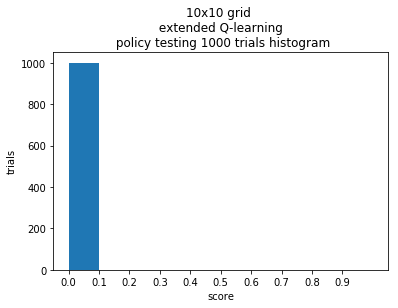

In [7]:
bins=np.linspace(0,1,11)
plt.hist(x=scores,bins=bins)
plt.ylabel('trials')
plt.xlabel('score')
plt.xticks(np.arange(0,1,0.1))
plt.title('10x10 grid \n extended Q-learning \n policy testing 1000 trials histogram')

Text(0.5, 1.0, '10x10 grid \n extended Q-learning \n policy testing 1000 trials histogram')

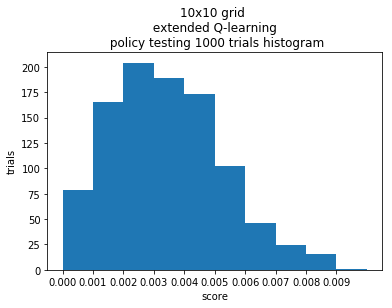

In [8]:
bins=np.linspace(0,0.01,11)
plt.hist(x=scores1,bins=bins)
plt.ylabel('trials')
plt.xlabel('score')
plt.xticks(np.arange(0,0.01,0.001))
plt.title('10x10 grid \n extended Q-learning \n policy testing 1000 trials histogram')

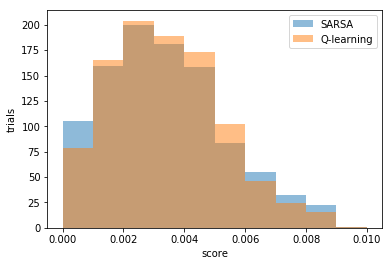

In [13]:
bins=np.linspace(0,0.01,11)

plt.hist(scores, bins, alpha=0.5, label='SARSA')
plt.hist(scores1, bins, alpha=0.5, label='Q-learning')
plt.ylabel('trials')
plt.xlabel('score')
plt.legend(loc='upper right')
plt.show()

In [14]:
import dill
dill.dump_session('notebook_env1.db')

